In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c santander-customer-transaction-prediction

 93% 232M/250M [00:01<00:00, 179MB/s]
100% 250M/250M [00:01<00:00, 173MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import six.moves.urllib as urllib
import sklearn
import scipy
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve,auc
import lightgbm as lgb
from tqdm import tqdm
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import pickle

In [ ]:
! unzip santander-customer-transaction-prediction.zip

Archive:  santander-customer-transaction-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
train=pd.read_csv('/content/train.csv')
train.head()


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
test=pd.read_csv('/content/test.csv')
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [ ]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [ ]:
train.columns


Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

##Training without Feature Engineering

In [ ]:
train_original=train.copy()
test_original=test.copy()
features=[c for c in train_original.columns if c not in ['ID_code','target']]
X_train_or=train_original.loc[:,features]
Y_train_or=train_original.loc[:,'target']
x_train_base,x_valid_base,y_train_base,y_valid_base=train_test_split(X_train_or,Y_train_or,test_size=0.2)
train_data_or=lgb.Dataset(x_train_base,y_train_base)
test_data_or=lgb.Dataset(x_valid_base,y_valid_base)

In [ ]:
###Default Parameter for LGBM
param_default = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
'metric':'auc',
'verbose':-100
 }
base_model=lgb.train(param_default,train_data_or,valid_sets=test_data_or,num_boost_round=10000,early_stopping_rounds=1000,verbose_eval=False)
y_train_base_pred = base_model.predict(x_train_base)
y_valid_base_pred = base_model.predict(x_valid_base)
print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train_base, y_train_base_pred),
                                                    roc_auc_score(y_valid_base, y_valid_base_pred)))

AUC Train: 0.9825
AUC Valid: 0.8759


In [ ]:
features=[c for c in train_original.columns if c not in ['ID_code','target']]
X_train_or=train_original.loc[:,features]
Y_train_or=train_original.loc[:,'target']
x_train_base,x_valid_base,y_train_base,y_valid_base=train_test_split(X_train_or,Y_train_or,test_size=0.2)
x_train_base.shape,y_train_base.shape,x_valid_base.shape,y_valid_base.shape

((160000, 200), (160000,), (40000, 200), (40000,))

In [ ]:
train_data_or=lgb.Dataset(x_train_base,y_train_base)
test_data_or=lgb.Dataset(x_valid_base,y_valid_base)

In [ ]:
###Default Parameter for LGBM
param_default = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
'metric':'auc',
'verbose':-100
 }

In [ ]:
base_model=lgb.train(param_default,train_data_or,valid_sets=test_data_or,num_boost_round=10000,early_stopping_rounds=1000,verbose_eval=False)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


In [ ]:
y_train_base_pred = base_model.predict(x_train_base)
y_valid_base_pred = base_model.predict(x_valid_base)

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train_base, y_train_base_pred),
                                                    roc_auc_score(y_valid_base, y_valid_base_pred)))

AUC Train: 0.9889
AUC Valid: 0.8766


So Base model without doing any feature engineering we are getting 0.8772 AUC score

###Base Model with Hyperparameter Tunning

In [ ]:
#Parameter after tunnning with Bayesian Optimiation
param_tune = {
    'bagging_freq': 20,
    'bagging_fraction': 0.9,
    'is_unbalance':'true',
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.21,
    'max_depth': 5,  
    'metric':'auc','min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 56,
    'num_threads': 86,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 0,
 'colsample_by_tree': 0.6615955550696031,
 'learning_rate': 0.02206947396833601,
 'min_child_samples': 600,
 'reg_alpha': 0.9603540271176727,
 'reg_lambda': 0.6376532349852623,
 "feature_pre_filter" : False,
    }

In [ ]:
base_model_tune=lgb.train(param_tune,train_data_or,valid_sets=test_data_or,num_boost_round=10000,early_stopping_rounds=1000,verbose_eval=False)

In [ ]:
y_train_base_tune=base_model_tune.predict(x_train_base)
y_test_base_tune=base_model_tune.predict(x_valid_base)
print("AUCTrain  {:.4f}\nAUCValid  {:.4f}".format(roc_auc_score(y_train_base,y_train_base_tune),
                                            roc_auc_score(y_valid_base,y_test_base_tune)))

AUCTrain  0.9808
AUCValid  0.8961


##Feature Engineering

####Adding Mathmatical Features

So, idea behind adding mathmatical features is that ia assume that for a particular customer if he invole in major features so it's sum,max and mean value will be high that can make impact as doing more transaction by that perticular customer

In [ ]:
index=features=train.columns.values[2:202]
for df in [train,test]:
    df['sum']=df[index].sum(axis=1)
    df['min']=df[index].min(axis=1)
    df['max']=df[index].max(axis=1)
    df['mean']=df[index].mean(axis=1)
    df['std']=df[index].std(axis=1)
    df['skew']=df[index].skew(axis=1)
    df['kurt']=df[index].kurtosis(axis=1)
    df['med']=df[index].median(axis=1)
train[train.columns[199:]].head(5)

,var_197,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
0,8.5635,12.7803,-1.0914,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,8.7889,18.3560,1.9518,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,8.2675,14.7222,0.3965,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,10.2922,17.9697,-8.9996,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,9.5031,17.9974,-8.8104,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [ ]:
train_1=train.copy()

In [ ]:
features_1=[c for c in train_1.columns if c not in ['ID_code','target']]

In [ ]:
x_1=train_1.loc[:,features_1]
y_1=train_1.loc[:,'target']

In [ ]:
x_1.shape

(200000, 208)

In [ ]:
y_1.shape

(200000,)

In [ ]:
x_train_1,x_valid_1,y_train_1,y_valid_1=train_test_split(x_1,y_1,test_size=0.2)
x_train_1.shape,x_valid_1.shape,y_train_1.shape,y_valid_1.shape

((160000, 208), (40000, 208), (160000,), (40000,))

In [ ]:
train_data_1=lgb.Dataset(x_train_1,y_train_1)
test_data_1=lgb.Dataset(x_valid_1,y_valid_1)

In [ ]:
base_model_2=lgb.train(param_default,train_data_1,valid_sets=test_data_1,num_boost_round=10000,early_stopping_rounds=1000,verbose_eval=False)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


In [ ]:
y_train_pred_1 = base_model_2.predict(x_train_1)
y_valid_pred_1 = base_model_2.predict(x_valid_1)

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train_1, y_train_pred_1),
                                                    roc_auc_score(y_valid_1, y_valid_pred_1)))

AUC Train: 0.9866
AUC Valid: 0.8768


In [ ]:
param_tune = {
    'bagging_freq': 20,
    'bagging_fraction': 0.9,
    'is_unbalance':'true',
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.21,
    'max_depth': 5,  
    'metric':'auc','min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 56,
    'num_threads': 86,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 0,
 'colsample_by_tree': 0.6615955550696031,
 'learning_rate': 0.02206947396833601,
 'min_child_samples': 600,
 'reg_alpha': 0.9603540271176727,
 'reg_lambda': 0.6376532349852623,
 "feature_pre_filter" : False,
    }

In [ ]:
base_model_2_tune=lgb.train(param_tune,train_data_1,valid_sets=test_data_1,num_boost_round=10000,early_stopping_rounds=1000,verbose_eval=False)

As I trained model with just adding mathmatical features we are getting better AUC as compair to before.

In [ ]:
y_train_pred_1_tune = base_model_2_tune.predict(x_train_1)
y_valid_pred_1_tune = base_model_2_tune.predict(x_valid_1)

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train_1, y_train_pred_1_tune),
                                                    roc_auc_score(y_valid_1, y_valid_pred_1_tune)))

AUC Train: 0.9847
AUC Valid: 0.8972


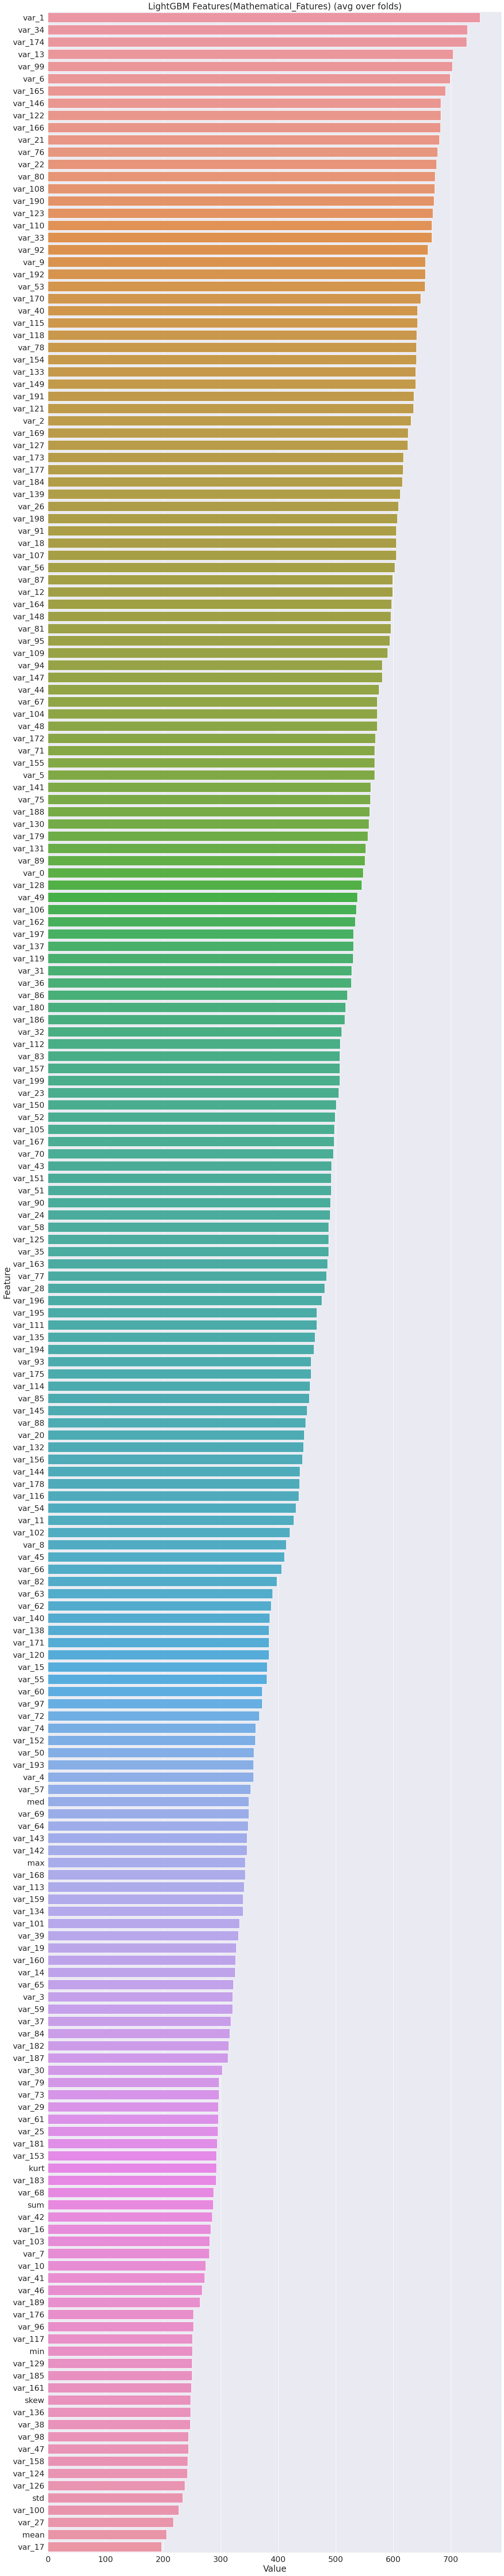

In [ ]:
feature_imp = pd.DataFrame({'Value':base_model_2_tune.feature_importance(),'Feature':features_1})
plt.figure(figsize=(20,100))
sns.set(font_scale = 2)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:208])
plt.title('LightGBM Features(Mathematical_Fatures) (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances-01.png')
plt.show()

###Observation:

1.   Kurt,skew median,sum having more importance as compair to some already present features
2.   Kurtosis is  most useful newely added features.



##Adding Unique value Features

1. So As we explore anonymous numerical date i decide to go 
for unsupervised approach for feature engineering i.e let suppose for any numerical value for a perticular feature of a customer and this value occured again on the same faeture with different customer we can say that second occured value is duplicate

2. We will add both train and test data as our sample data corpus so it will be more accurate to find the unique and duplicate value

3. We will first examine this scenario with test and will check the outcomes 




In [ ]:
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [ ]:
column_names=[f"var_{i}" for i in range(200)]
for col in tqdm(column_names):
    count=test[col].value_counts()            #check count of every test value
    uniques=count.index[count==1]             # if count==1 value is unique
    test[col+"_u"]=test[col].isin(uniques)
test['has_unique']=test[[col+"_u"for col in column_names]].any(axis=1)
real_test=test.loc[test['has_unique'],['ID_code']+column_names]
fake_test=test.loc[~test['has_unique'],['ID_code']+column_names]
train_test_combined=pd.concat([train,real_test],axis=0)
for col in tqdm(column_names):
    count=train_test_combined[col].value_counts().to_dict()
    train_test_combined[col+'_unique']=train_test_combined[col].apply(lambda x:1 if count[x]==1 else 0).values
    fake_test[col+'_unique']=0
real_test=train_test_combined[train_test_combined['ID_code'].str.contains('test')].copy()
real_test.drop(['target'],axis=1,inplace=True)
train_final=train_test_combined[train_test_combined['ID_code'].str.contains('train')].copy()
train_final.shape,real_test.shape

 48%|████▊     | 96/200 [00:38<00:36,  2.86it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if sys.path[0] == '':
 49%|████▉     | 98/200 [00:39<00:44,  2.29it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
100%|██████████| 200/200 [01:18<00:00,  2.55it/s]


((200000, 410), (100000, 409))

In [ ]:
column_names=[f"var_{i}" for i in range(200)]
for col in tqdm(column_names):
    count=test[col].value_counts()            #check count of every test value
    uniques=count.index[count==1]             # if count==1 value is unique
    #print(count)
    #print(unique)
    test[col+"_u"]=test[col].isin(uniques)
test['has_unique']=test[[col+"_u"for col in column_names]].any(axis=1)

 47%|████▋     | 94/200 [00:02<00:02, 41.10it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
100%|██████████| 200/200 [00:04<00:00, 41.22it/s]


Now we will filter out real test sample from test data with the help of unique values

In [ ]:
real_test=test.loc[test['has_unique'],['ID_code']+column_names]
fake_test=test.loc[~test['has_unique'],['ID_code']+column_names]
train_test_combined=pd.concat([train,real_test],axis=0)
real_test.shape,fake_test.shape

((100000, 201), (100000, 201))

It is observer that 50 % of our test data is fake.So we will take only this 50 % of test data for submission and prediction.

In [ ]:
train_test_combined.shape

(300000, 210)

50% of test data sample was fake

In [ ]:
for col in tqdm(column_names):
    count=train_test_combined[col].value_counts().to_dict()
    train_test_combined[col+'_unique']=train_test_combined[col].apply(lambda x:1 if count[x]==1 else 0
                                                                     ).values
    fake_test[col+'_unique']=0

100%|██████████| 200/200 [01:09<00:00,  2.90it/s]


In [ ]:
train_test_combined.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190_unique', 'var_191_unique', 'var_192_unique', 'var_193_unique',
       'var_194_unique', 'var_195_unique', 'var_196_unique', 'var_197_unique',
       'var_198_unique', 'var_199_unique'],
      dtype='object', length=410)

Here we are assigning 1 to a unique numerical value and 0 for fake value.

In [ ]:
real_test=train_test_combined[train_test_combined['ID_code'].str.contains('test')].copy()
real_test.drop(['target'],axis=1,inplace=True)

In [ ]:
real_test.shape

(100000, 409)

Here we are filtering our test data sample from whole train_test combined sample.

In [ ]:
train_final=train_test_combined[train_test_combined['ID_code'].str.contains('train')].copy()

In [ ]:
train_final.shape


(200000, 402)

In [ ]:
real_test.shape

(100000, 409)

So after feature Engineering we added 8 mathmatecial features and 200 unique features for every respective columns

###Model Training

In [ ]:
features_final = [c for c in train_final.columns if c not in ['ID_code','target']]
X = train_final.loc[:, features_final]
y = train_final.loc[:, 'target']
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2)
train_data=lgb.Dataset(X_train,y_train)
valid_data=lgb.Dataset(X_valid,y_valid)

In [ ]:
param_default = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
'metric':'auc'
 }
model_lgbm=lgb.train(param_default,train_data,valid_sets=valid_data,num_boost_round=10000,early_stopping_rounds=1000,verbose_eval=False)
y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_valid)

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_valid, y_valid_pred)))

AUC Train: 0.9920
AUC Valid: 0.8928


we are getting AUC score of 0.8928 with default hyperparameter of LGBM

####Hyperparameter Tunning

for Hyperparameter tunning we will use 'Bayesian optimization' approach instead of RandomSearch or Grid Search,as it is less time consuming as it takes past compution also in count.
I took reference of amazing blog of "Automated Machine Learning Hyperparameter Tuning in Python" and understand bayesian optimization.[link text](https://https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a)

In [ ]:
import lightgbm as lgb
from hyperopt import STATUS_OK

folds = 5

def objective(params, n_folds = folds):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""
    
    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evalute based on ROC AUC
    cv_results = lgb.cv(params, train_data, nfold = n_folds, num_boost_round = 10000 ,
                        early_stopping_rounds = 1000,metrics = 'auc', seed = 50)
  
    # Extract the best score
    best_score = max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [ ]:
from hyperopt import hp
from hyperopt import fmin
from hyperopt import tpe
from hyperopt import Trials
space = {
    'num_leaves': hp.choice('num_leaves', np.arange(30, 150, dtype=int)),
    'num_threads': hp.choice('num_threads', np.arange(30, 150, dtype=int)),
    'bagging_freq':hp.choice('bagging_freq', np.arange(30, 100,dtype=int)),
    'feature_fraction': hp.choice('feature_fraction',np.arange(0.1,1,dtype=float)),
    'max_depth':hp.choice('max_depth', np.arange(1,50, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.choice('subsample_for_bin', np.arange(20000, 300000, 20000,dtype=int)),
    'bagging_fraction': hp.choice('bagging_fraction',np.arange(0.1,1,dtype=float)),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_alpha': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'reg_lambda':hp.uniform('colsample_by_tree', 0.1, 1.0),
    "feature_pre_filter" : False
}
# Algorithm
tpe_algorithm = tpe.suggest
# Trials object to track progress
bayes_trials = Trials()
MAX_EVALS = 10
# Optimize
best = fmin(fn = objective, space = space,algo = tpe.suggest,
            max_evals = MAX_EVALS, trials = bayes_trials)

 During optimization, the TPE algorithm constructs the probability model from the past results and decides the next set of hyperparameters to evaluate in the objective function by maximizing the expected improvement.

In [ ]:
from hyperopt import tpe
# Algorithm
tpe_algorithm = tpe.suggest

we want to find out what is going on behind the scenes, we can use a Trials object which will store basic training information and also the dictionary returned from the objective function (which includes the loss and params )

In [ ]:
from hyperopt import Trials
# Trials object to track progress
bayes_trials = Trials()

Each iteration, the algorithm chooses new hyperparameter values from the surrogate function which is constructed based on the previous results and evaluates these values in the objective function. This continues for MAX_EVALS evaluations of the objective function with the surrogate function continually updated with each new result.

In [ ]:
from hyperopt import fmin

MAX_EVALS = 10

# Optimize
best = fmin(fn = objective, space = space,algo = tpe.suggest,
            max_evals = MAX_EVALS, trials = bayes_trials)

In [ ]:
param_tune = {'bagging_freq': 20,
    'bagging_fraction': 0.9,
    'is_unbalance':'true',
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.21,
    'max_depth': 5,  
    'metric':'auc','min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 56,
    'num_threads': 86,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 0,
 'colsample_by_tree': 0.6615955550696031,
 'learning_rate': 0.02206947396833601,
 'min_child_samples': 600,
 'reg_alpha': 0.9603540271176727,
 'reg_lambda': 0.6376532349852623,
 "feature_pre_filter" : False,
    }
model_lgbm_tune=lgb.train(param_tune,train_data,valid_sets=valid_data,num_boost_round=15000,early_stopping_rounds=1000,verbose_eval=False)
y_train_pred_tune = model_lgbm_tune.predict(X_train)
y_valid_pred_tune = model_lgbm_tune.predict(X_valid)
print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred_tune),
                                                    roc_auc_score(y_valid, y_valid_pred_tune)))

AUC Train: 0.9956
AUC Valid: 0.9061


So,After tunning of parameter we are getting AUC score of 0.9061.

###Feature Importance

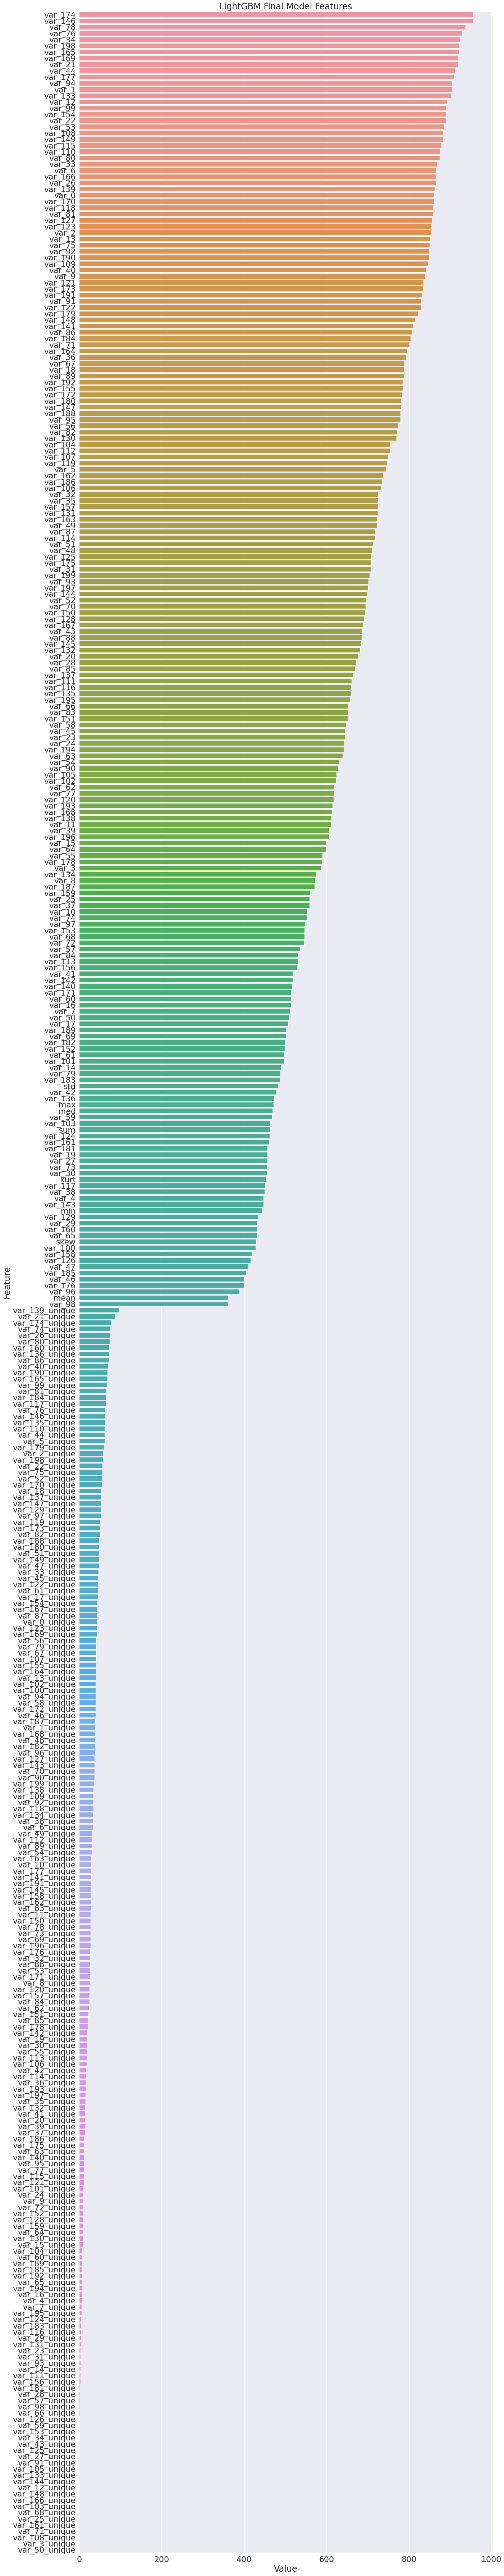

In [ ]:
feature_imp = pd.DataFrame({'Value':model_lgbm_tune.feature_importance(),'Feature':features_final})
plt.figure(figsize=(20,100))
sns.set(font_scale = 2)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:408])
plt.title('LightGBM Final Model Features')
plt.tight_layout()
plt.savefig('lgbm_importance.png')
plt.show()

In [ ]:
real_test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190_unique,var_191_unique,var_192_unique,var_193_unique,var_194_unique,var_195_unique,var_196_unique,var_197_unique,var_198_unique,var_199_unique
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,0,0,0,0,0,0,0,0,0,1
7,test_7,17.3035,-2.4212,13.3989,8.3998,11.0777,9.6449,5.9596,17.8477,-4.8068,...,0,0,0,0,0,0,0,0,1,0
11,test_11,10.6137,-2.1898,8.9090,3.8014,13.8602,-5.9802,5.5515,15.4716,-0.1714,...,0,0,0,0,0,0,1,0,0,1
15,test_15,14.8595,-4.5378,13.6483,5.6480,9.9144,1.5190,5.0358,13.4524,-2.5419,...,0,0,1,0,0,0,0,0,0,1
16,test_16,14.1732,-5.1490,9.7591,3.7316,10.3700,-21.9202,7.7130,18.8749,0.4680,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print("+-----------------------------MODEL_TABLE---------------------------+")
print("Model                                                    AUC score")
print("Base_Model                                         ",(roc_auc_score(y_valid_base, y_valid_base_pred)))
print("Base_Model with Hyperparameter Tunning             ",roc_auc_score(y_valid_base,y_test_base_tune))
print("Model with Mathematical Features                   ",roc_auc_score(y_valid_1, y_valid_pred_1))
print("Mathematical model with hyperparameter tunning      ",roc_auc_score(y_valid_1, y_valid_pred_1_tune))
print("Final_Model without tunning                        ",roc_auc_score(y_valid, y_valid_pred))
print("Final_Model with Hyperparameter tunning            ",roc_auc_score(y_valid, y_valid_pred_tune))

*************MODEL_TABLE**********
Model                                                    AUC score
Base_Model                                          0.8766006782306185
Base_Model with Hyperparameter Tunning              0.8960523423544939
Model with Mathematical Features                    0.8768032889322481
Mathematical model with hyperparameter tunning       0.897203705113332
Final_Model without tunning                         0.8953827849267713
Final_Model with Hyperparameter tunning             0.9070237869040833


In [ ]:
test_sample=real_test.drop(['ID_code'],axis=1)
y_pred_test = model_lgbm_tune.predict(test_sample)
submission = pd.DataFrame({'ID_code': real_test.ID_code, 
                       'target': y_pred_test})
submission.head()

,ID_code,target
3,test_3,0.434621
7,test_7,0.347185
11,test_11,0.118773
15,test_15,0.124744
16,test_16,0.775371


In [ ]:
filename="Customer_transaction_prediction_model.pkl"
pickle.dump(model_lgbm_tune,open(filename,'wb'))

In [ ]:
submission.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved,THANK YOU")

Your submission was successfully saved,THANK YOU
